## **FEW-SHOT OBJECT DETECTION (FSOD) METHODS IN DETECTING AERIAL IMAGES - FINE-TUNING APPROACH USING FASTER-RCNN MODEL**


### **Introduction to the NWPU VHR-10 Dataset**

**VHR-10** (Very High Resolution — 10 classes) is a remote sensing dataset with high-resolution aerial images, provided by the **Northwestern Polytechnical University (NWPU), China**.  

---

#### 📌 **Structure and Composition**

- The dataset consists of:

  - **Positive image set** (650 images): containing at least one object of interest.

  - **Negative image set** (150 images): containing no objects of interest.

- The 10 object classes included in the positive set are:

<div style="margin-bottom:10px; margin-left:40px">

  | Class | Number of Objects |
  |---|---|
  | Airplanes | 757 |
  | Ships | 302 |
  | Storage tanks | 655 |
  | Baseball diamonds | 390 |
  | Tennis courts | 524 |
  | Basketball courts | 159 |
  | Ground track fields | 163 |
  | Harbors | 224 |
  | Bridges | 124 |
  | Vehicles | 477 |

</div>

- Each image is annotated with:

  - Bounding boxes for object detection.

  - Instance segmentation masks (if provided).  

---

#### 📌 **Main Applications**

The NWPU VHR-10 dataset is commonly used for:
- Object detection research in remote sensing imagery.

- Benchmarking models on small and challenging objects.

- Testing generalization capabilities on aerial views.  

---

#### 📌 **Key Notes**

1. **Class imbalance**  
   Some classes (e.g., *Airplanes*, *Storage tanks*) have many objects, while others (e.g., *Bridges*) have far fewer, leading to an imbalanced dataset.

2. **Negative images**  
   The inclusion of negative images helps in evaluating false positive rates of detection models.

3. **High-resolution imagery**  
   Small objects occupy very few pixels in high-resolution images, making small object detection a crucial challenge.

4. **Format compatibility**  
   For use with frameworks such as COCO or Pascal VOC, annotations may need to be converted into the appropriate format.
  
---

#### 📌 **References**
**Kaggle dataset link**: [NWPU VHR-10](https://www.kaggle.com/datasets/larbisck/nwpu-vhr-10)

---

### **I. Download and Pre-processing**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("larbisck/nwpu-vhr-10")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nwpu-vhr-10' dataset.
Path to dataset files: /kaggle/input/nwpu-vhr-10


In [2]:
import os, json, random, shutil
import cv2

# Base directories
root_dir = "/kaggle/input/nwpu-vhr-10/NWPU VHR-10 dataset"
pos_dir = os.path.join(root_dir, "positive image set")
gt_dir = os.path.join(root_dir, "ground truth")

out_dir = "/kaggle/working/nwpu_fsod"
os.makedirs(out_dir, exist_ok=True)

# Mapping class
id2cls = {
    1: "airplane", 2: "ship", 3: "storage tank", 4: "baseball diamond", 5: "tennis court",
    6: "basketball court", 7: "ground track field", 8: "harbor", 9: "bridge", 10: "vehicle"
}

base_classes = [1,2,3,4,5,6,7]
novel_classes = [8,9,10]
shots = 5  # k-shot

split_dirs = {
    "base_train": os.path.join(out_dir, "base_train"),
    "novel_support": os.path.join(out_dir, "novel_support"),
    "novel_query": os.path.join(out_dir, "novel_query")
}
for d in split_dirs.values():
    os.makedirs(d, exist_ok=True)

def parse_gt(gt_path, filter_cids=None):
    anns = []
    with open(gt_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                coords, cid = line.rsplit(",", 1)
                x1y1, x2y2 = coords.split("),(")
                x1y1 = x1y1.replace("(","").replace(")","")
                x2y2 = x2y2.replace("(","").replace(")","")
                x1, y1 = map(int, x1y1.split(","))
                x2, y2 = map(int, x2y2.split(","))
                cid = int(cid.strip())
            except:
                continue
            if filter_cids and cid not in filter_cids:
                continue
            w, h = x2 - x1, y2 - y1
            if w <= 0 or h <= 0:
                continue
            anns.append({"category_id":cid, "bbox":[x1,y1,w,h], "area":w*h, "iscrowd":0})
    return anns

# Build full mapping: img -> base/novel bboxes
all_images = [f for f in os.listdir(pos_dir) if f.lower().endswith(".jpg")]
img_to_bboxes = {}
for fname in all_images:
    gt_path = os.path.join(gt_dir, fname.replace(".jpg",".txt"))
    img_to_bboxes[fname] = {
        "base": parse_gt(gt_path, filter_cids=base_classes),
        "novel": parse_gt(gt_path, filter_cids=novel_classes)
    }

all_novel_imgs = [fname for fname in all_images
                  if img_to_bboxes[fname]["novel"]
                  and not img_to_bboxes[fname]["base"]]

# Prepare novel support k-shot
novel_support_imgs = []
for cid in novel_classes:
    imgs_with_cid = [fname for fname in all_novel_imgs
                     if any(ann["category_id"] == cid for ann in img_to_bboxes[fname]["novel"])]
    random.shuffle(imgs_with_cid)
    novel_support_imgs.extend(imgs_with_cid[:shots])

# Remove duplicates
novel_support_imgs = list(set(novel_support_imgs))

# Novel query = all novel images excluding support
novel_query_imgs = [fname for fname in all_novel_imgs if fname not in novel_support_imgs]

# Base train = all images with base bboxes
base_train_imgs = [fname for fname in all_images
                   if fname not in novel_support_imgs
                   and fname not in novel_query_imgs]

# Initialize COCO splits
coco_splits = {k: {"images":[], "annotations":[], "categories":[] } for k in split_dirs}
ann_id = 1
img_id_counter = 1

# Add categories
for cid, cname in id2cls.items():
    for split in coco_splits.values():
        split["categories"].append({"id": cid, "name": cname})

# Helper to copy images and add to coco
def add_image(fname, split_name, bboxes=None, prefix=""):
    global ann_id, img_id_counter
    img_path = os.path.join(pos_dir, fname)
    dst_fname = f"{prefix}{fname}" if prefix else fname
    shutil.copy(img_path, os.path.join(split_dirs[split_name], dst_fname))
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    coco_splits[split_name]["images"].append({"id": img_id_counter, "file_name": dst_fname, "width": w, "height": h})
    if bboxes:
        for ann in bboxes:
            ann_copy = ann.copy()
            ann_copy["image_id"] = img_id_counter
            ann_copy["id"] = ann_id
            ann_id += 1
            coco_splits[split_name]["annotations"].append(ann_copy)
    img_id_counter +=1

# Base train
for fname in base_train_imgs:
    add_image(fname, "base_train", bboxes=img_to_bboxes[fname]["base"])

# Novel support
for fname in novel_support_imgs:
    add_image(fname, "novel_support", bboxes=img_to_bboxes[fname]["novel"])

# Novel query (no bbox)
for fname in novel_query_imgs:
    add_image(fname, "novel_query", bboxes=img_to_bboxes[fname]["novel"])

# Save JSONs
for split, path in split_dirs.items():
    json_path = os.path.join(out_dir, f"{split}.json")
    with open(json_path, "w") as f:
        json.dump(coco_splits[split], f)

print("FSOD NWPU splits done! JSONs and images saved in:", out_dir)
print("Base train:", len(base_train_imgs))
print("Novel support:", len(novel_support_imgs))
print("Novel query:", len(novel_query_imgs))


FSOD NWPU splits done! JSONs and images saved in: /kaggle/working/nwpu_fsod
Base train: 482
Novel support: 15
Novel query: 153


### **II. Train model**

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset class
class NWPUFSODDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.img_dir = img_dir
        with open(ann_file, "r") as f:
            self.coco = json.load(f)
        self.images = self.coco["images"]
        self.anns = self.coco["annotations"]
        self.img_id_to_anns = {}
        for ann in self.anns:
            self.img_id_to_anns.setdefault(ann["image_id"], []).append(ann)
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info["file_name"])
        img = cv2.imread(img_path)[:,:,::-1]  # BGR to RGB
        img = img.copy()
        img = torch.from_numpy(img).permute(2,0,1).float()/255.0

        img_id = img_info["id"]
        anns = self.img_id_to_anns.get(img_id, [])

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            x_max = x + w
            y_max = y + h
            boxes.append([x, y, x_max, y_max])
            labels.append(ann["category_id"])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Paths
base_train_dir = "/kaggle/working/nwpu_fsod/base_train"
base_train_json = "/kaggle/working/nwpu_fsod/base_train.json"

# Dataset & DataLoader
dataset = NWPUFSODDataset(base_train_dir, base_train_json)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load Faster R-CNN pretrained
num_classes = 11  # 10 classes + background
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, targets in data_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "/kaggle/working/fasterrcnn_base_finetuned.pth")
print("Model saved at fasterrcnn_base_finetuned.pth")


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 194MB/s]


Epoch 1/5, Loss: 153.2399
Epoch 2/5, Loss: 85.6047
Epoch 3/5, Loss: 69.6492
Epoch 4/5, Loss: 62.1583
Epoch 5/5, Loss: 55.8699
Model saved at fasterrcnn_base_finetuned.pth


In [4]:
model.load_state_dict(torch.load("/kaggle/working/fasterrcnn_base_finetuned.pth", map_location=device))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### **III. Fine-tune model**

In [5]:
support_dataset = NWPUFSODDataset("/kaggle/working/nwpu_fsod/novel_support",
                                  "/kaggle/working/nwpu_fsod/novel_support.json")
support_loader = DataLoader(support_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Only fine-tune the head
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_head.parameters():
    param.requires_grad = True
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

# Optimizer: only head parameters
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.03, momentum=0.9
)

# Fine-tune loop (1-2 epochs)
model.train()
for epoch in range(2):
    epoch_loss = 0
    for imgs, targets in support_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
    print(f"Epoch {epoch+1}/2, Loss: {epoch_loss:.4f}")

# Save fine-tuned head
torch.save(model.state_dict(), "/kaggle/working/fasterrcnn_fewshot_head.pth")
print("Fine-tuned head saved!")

Epoch 1/2, Loss: 16.9425
Epoch 2/2, Loss: 13.7044
Fine-tuned head saved!


In [6]:
model.load_state_dict(torch.load("/kaggle/working/fasterrcnn_fewshot_head.pth", map_location=device))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### **IV. Prediction**

In [7]:
import json
import torch

# Load query dataset
query_dataset = NWPUFSODDataset("/kaggle/working/nwpu_fsod/novel_query",
                                "/kaggle/working/nwpu_fsod/novel_query.json")
query_loader = DataLoader(query_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


all_predictions = []

model.eval()
with torch.no_grad():
    for idx, (imgs, targets) in enumerate(query_loader):
        imgs = list(img.to(device) for img in imgs)
        outputs = model(imgs)

        for i, output in enumerate(outputs):
            img_id = query_dataset.images[idx]["id"]
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            for b, l, s in zip(boxes, labels, scores):
                if s < 0.05:  # Accept threshold
                    continue

                # COCO format: [x, y, width, height]
                x, y, x2, y2 = b
                w = x2 - x
                h = y2 - y
                all_predictions.append({
                    "image_id": img_id,
                    "category_id": int(l),
                    "bbox": [float(x), float(y), float(w), float(h)],
                    "score": float(s)
                })

# Save predictions to JSON
with open("/kaggle/working/predictions.json", "w") as f:
    json.dump(all_predictions, f)


### **V. Evaluation**

In [9]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import json

# Load GT (file annotation coco format)
coco_gt = COCO("/kaggle/working/nwpu_fsod/novel_query.json")

coco_gt.dataset["info"] = {}
coco_gt.dataset["licenses"] = {}

# Load predictions
coco_dt = coco_gt.loadRes("/kaggle/working/predictions.json")

# Eval
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.iouThrs = np.linspace(0.5, 0.95, 10)
coco_eval.params.catIds = [8, 9, 10]
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### **VI. Visualization**

Saved SVG to: /kaggle/working/eval_metrics.svg


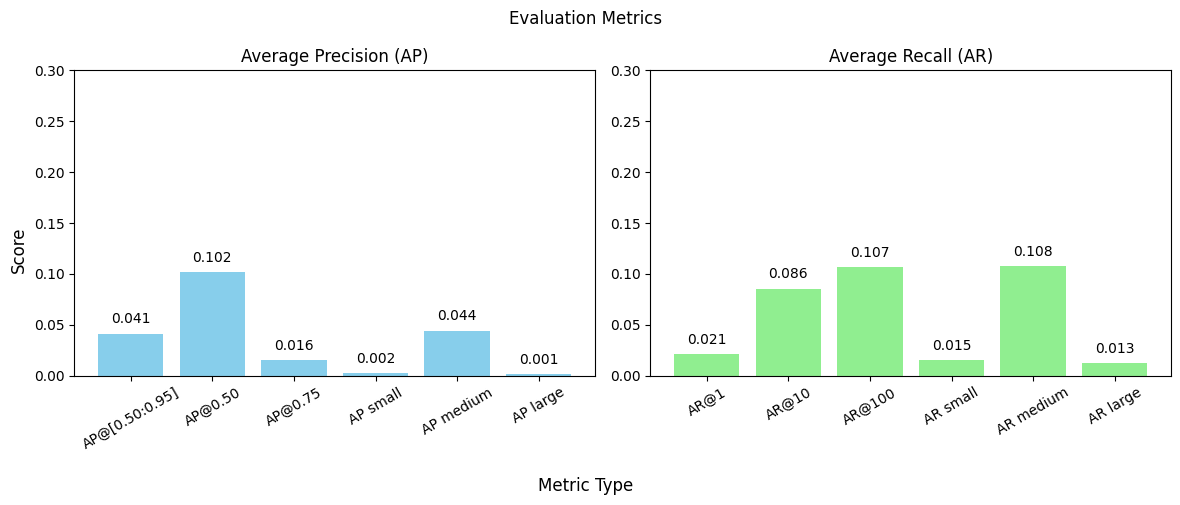

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get result from coco_eval.stats
stats = coco_eval.stats

# stats[0] = AP IoU=0.50:0.95
# stats[1] = AP IoU=0.50
# stats[2] = AP IoU=0.75
# stats[3] = AP small
# stats[4] = AP medium
# stats[5] = AP large
# stats[6] = AR maxDets=1
# stats[7] = AR maxDets=10
# stats[8] = AR maxDets=100
# stats[9] = AR small
# stats[10] = AR medium
# stats[11] = AR large

# Get AP and AR
ap_labels = ["AP@[0.50:0.95]", "AP@0.50", "AP@0.75", "AP small", "AP medium", "AP large"]
ar_labels = ["AR@1", "AR@10", "AR@100", "AR small", "AR medium", "AR large"]

ap_values = stats[:6]
ar_values = stats[6:]

# Draw plot
fig, axes = plt.subplots(1, 2, figsize=(12,5))

fig.suptitle("Evaluation Metrics")
fig.supxlabel("Metric Type")
fig.supylabel("Score")

# Bar chart AP
axes[0].set_ylim(0, 0.3)
axes[0].bar(ap_labels, ap_values, color="skyblue")
axes[0].set_title("Average Precision (AP)")
axes[0].tick_params(axis="x", rotation=30)
for i, v in enumerate(ap_values):
    axes[0].text(i, v+0.01, f"{v:.3f}", ha="center")

# Bar chart AR
axes[1].set_ylim(0, 0.3)
axes[1].bar(ar_labels, ar_values, color="lightgreen")
axes[1].set_title("Average Recall (AR)")
axes[1].tick_params(axis="x", rotation=30)
for i, v in enumerate(ar_values):
    axes[1].text(i, v+0.01, f"{v:.3f}", ha="center")

plt.tight_layout()

# Save as SVG (Kaggle working dir)
out_path = "/kaggle/working/eval_metrics.svg"
plt.savefig(out_path, format="svg", bbox_inches="tight")
print(f"Saved SVG to: {out_path}")

plt.show()

### **VII. Report**

- **Average Precision (AP)**:

  - The overall AP across IoU thresholds (0.50:0.95) is 0.041, which is very low, indicating that the model struggles with robust detection in the few-shot setting.

  - At a more lenient threshold (IoU=0.50), AP increases to 0.102, suggesting that the model can identify some object instances when precise localization is not strictly required.

  - At a stricter IoU (0.75), AP drops sharply to 0.016, confirming difficulties in accurate localization.

  - Regarding object size, the model performs poorly on small (0.002) and large (0.001) objects, while performance for medium objects is slightly better (0.044). Although still weak, this indicates the model is somewhat more capable of detecting medium-sized instances.

- **Average Recall (AR)**:

  - Recall values are consistently higher than precision, implying that the model generates correct detections but struggles with confidence scores or bounding-box alignment.

  - AR@1 = 0.021 shows that the model rarely retrieves the correct object with its top prediction, but performance improves when more predictions are considered: AR@10 = 0.086 and AR@100 = 0.107.

  - For object sizes, recall follows a similar trend as precision: small objects = 0.015 and large objects = 0.013, while medium objects achieve better recall (0.108). This suggests the model can detect medium-sized instances more reliably than very small or large ones.

### **VIII. Interpretation**
- While the absolute performance is weak, this outcome is not unexpected in Few-Shot Object Detection, where the model has access to very limited data.

- The fact that it achieves non-zero AP and AR for medium objects is a positive sign, indicating that the model has already learned a basic understanding of object presence.

- With further fine-tuning, data augmentation, or additional support samples, these metrics are likely to improve, particularly in terms of localization and detection of small and large objects.